# Transfer learning model results

---

**Model parameters:**

Image types: `Color`, `Grayscale`, `Segmented`

Images size: `256x256`

Model type: `InceptionV3` 

Train-test splits: `70-30`, `50-50`, `30-70`

**Comments:**

Baseline results for InceptionV3 tranfer learning models are included below. Validation accuracy of 99.5% is achieved on a 30% validation set for a model trained using color images. The majority of misclassifications are within specie errors, with only a handful of cases where the predicted specie is inconsistent with that suggested by the label. As might be expected the models trained using the equivalent grayscale images perform worse, but still manage to achieve validation accuracies above 97%.

The model were all run for 20 epochs with each epoch consisting of 500 training and validation steps. The models were trained using Nvidia Tesla K40 GPUs on Odyssey and took in the order of 7 hours to train in parallel.

## Setup and data import

In [1]:
import os
import re
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import load_model
from keras.preprocessing import image

from sklearn.metrics import confusion_matrix
from tqdm import tqdm

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

sns.set_palette('deep')
sns.set_context('notebook', font_scale=1.2)

vc_color = '#B5C9EB'

Using TensorFlow backend.


In [2]:
TRAIN_DIR = "../data/raw/plant_diseases/color/70_30_HR/train/"
VAL_DIR = "../data/raw/plant_diseases/color/70_30_HR/validation/"
MODEL_DIR = "../models/transfer_learning/"

In [3]:
IM_WIDTH, IM_HEIGHT = 299, 299 
BATCH_SIZE = 32

In [4]:
# Get image classes
classes = os.listdir(TRAIN_DIR)
num_classes = len(classes)
print(f"Number of classes: {num_classes}")

Number of classes: 38


In [5]:
# Get path and label for each image
db=[]
for label, class_name in enumerate(classes):
    
    # Train
    path = TRAIN_DIR + class_name
    for file in os.listdir(path):
        db.append(['{}/{}'.format(class_name, file), label, class_name, 1])

    # Validation
    path = VAL_DIR + class_name
    for file in os.listdir(path):
        db.append(['{}/{}'.format(class_name, file), label, class_name, 0])

db = pd.DataFrame(db, columns=['file', 'label', 'class_name', 'train_ind'])

num_train_samples = db.train_ind.sum()
num_val_samples = len(db) - num_train_samples

print(f"Number of train images: {num_train_samples}")
print(f"Number of validation images: {num_val_samples}")

Number of train images: 38089
Number of validation images: 16216


In [6]:
# Validation generator
training_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

training_generator = training_datagen.flow_from_directory(
  TRAIN_DIR,
  target_size=(IM_WIDTH, IM_HEIGHT),
  batch_size=BATCH_SIZE,
  shuffle=False)

# Validation generator
validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

validation_generator = validation_datagen.flow_from_directory(
  VAL_DIR,
  target_size=(IM_WIDTH, IM_HEIGHT),
  batch_size=BATCH_SIZE,
  shuffle=False)

Found 38089 images belonging to 38 classes.
Found 16216 images belonging to 38 classes.


## Baseline model performance

In [7]:
# Load model
model = load_model(MODEL_DIR + "inception_color_70_30.hdf5")

In [8]:
# # Evaluate model performance
# loss, acc = model.evaluate_generator(validation_generator)

# print("Validation loss: {0:.4f}".format(loss))
# print("Validation accuracy: {0:.4f}".format(acc))

In [9]:
# Get true labels
y_class = db.loc[db.train_ind == 0, 'label']

# Get predictions for validation data
pred_prob = model.predict_generator(validation_generator, verbose=0)
pred_class = np.argmax(pred_prob, -1)

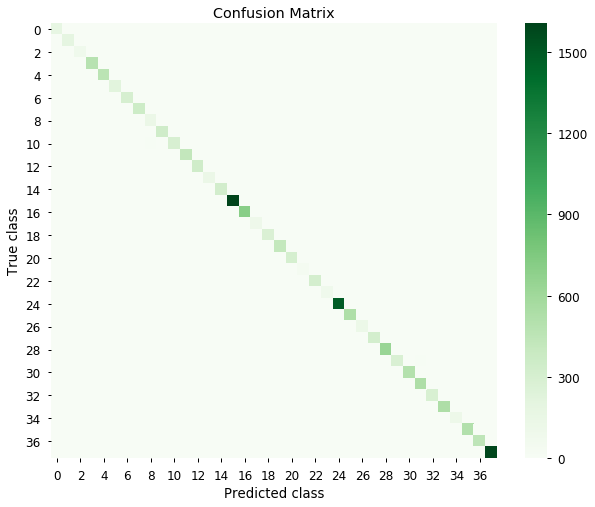

In [35]:
# Plot confusion matrix
cm = confusion_matrix(y_class, pred_class)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax = sns.heatmap(cm, ax=ax, cmap=plt.cm.Greens)
plt.title('Confusion Matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.yticks(rotation=0)
plt.show();

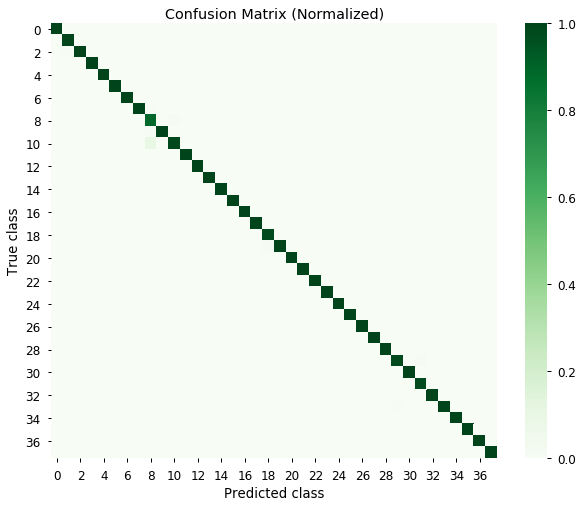

In [36]:
cm_std = cm / np.sum(cm, axis=0)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax = sns.heatmap(cm_std, ax=ax, cmap=plt.cm.Greens)
plt.title('Confusion Matrix (Normalized)')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.yticks(rotation=0)
plt.show();

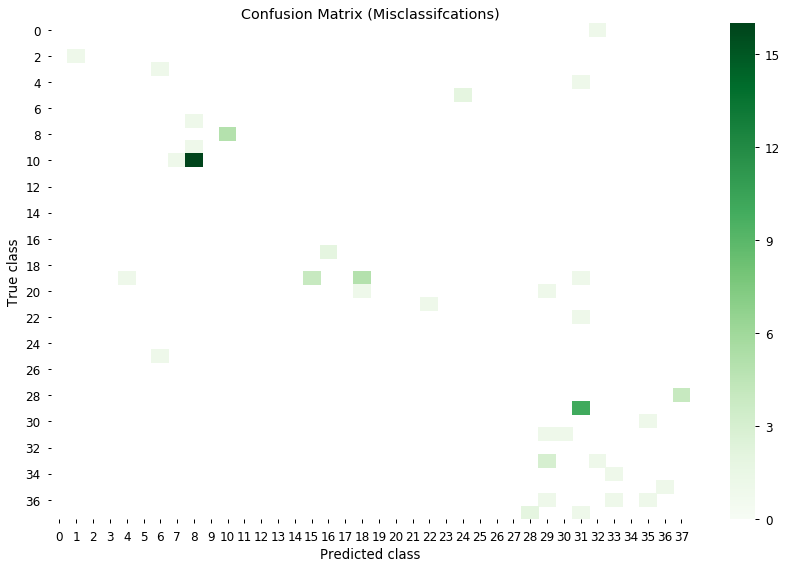

In [37]:
cm_err = cm
np.fill_diagonal(cm_err, 0)
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
msk = cm_err == 0
ax = sns.heatmap(cm_err, ax=ax, cmap=plt.cm.Greens, annot=False, mask=msk)
plt.title('Confusion Matrix (Misclassifcations)')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("images/confusion_matrix.png")
plt.show();

In [38]:
# Check misclassified images
correct = pred_class == y_class
print(f"Total number of misclassified images: {np.sum(1-correct)}")

Total number of misclassified images: 77


In [39]:
def get_specie_name(s):
    return re.findall(".+?___", s)[0][:-3]

In [40]:
name_mapping = db.groupby(['label', 'class_name'])['file'].count()
name_mapping = name_mapping.reset_index()
name_mapping.drop('file', axis=1, inplace=True)

In [41]:
db_val = db.loc[db.train_ind == 0,:]
db_error = db_val[~correct]
db_error['pred'] = pred_class[~correct]

In [42]:
df = db_error.groupby(['label', 'pred'])['file'].count()
df = df.reset_index()

df = df.merge(name_mapping, left_on='label', right_on='label')
df.rename(columns={'class_name':'label_name'}, inplace=True)

df = df.merge(name_mapping, left_on='pred', right_on='label')
df.rename(columns={'class_name':'pred_name'}, inplace=True)
df.rename(columns={'label_x':'label'}, inplace=True)
df.rename(columns={'file':'count'}, inplace=True)
df.drop('label_y', axis=1, inplace=True)

df['label_specie'] = df.label_name.apply(get_specie_name)
df['pred_specie'] = df.pred_name.apply(get_specie_name)
df['specie_error'] = df.apply(lambda s: 1 * (s.label_specie != s.pred_specie) , axis=1)
df

,label,pred,count,label_name,pred_name,label_specie,pred_specie,specie_error
0,0,32,1,Apple___apple_scab,Tomato___leaf_mold,Apple,Tomato,1
1,33,32,1,Tomato___leaf_spot,Tomato___leaf_mold,Tomato,Tomato,0
2,2,1,1,Apple___cedar_apple_rust,Apple___black_rot,Apple,Apple,0
3,3,6,1,Apple___healthy,Cherry___powdery_mildew,Apple,Cherry,1
4,25,6,1,Squash___powdery_mildew,Cherry___powdery_mildew,Squash,Cherry,1
5,4,31,1,Blueberry___healthy,Tomato___late_blight,Blueberry,Tomato,1
6,19,31,1,Pepperbell___healthy,Tomato___late_blight,Pepperbell,Tomato,1
7,22,31,1,Potato___late_blight,Tomato___late_blight,Potato,Tomato,1
8,29,31,10,Tomato___early_blight,Tomato___late_blight,Tomato,Tomato,0
9,37,31,1,Tomato___yellow_leaf_curl_virus,Tomato___late_blight,Tomato,Tomato,0


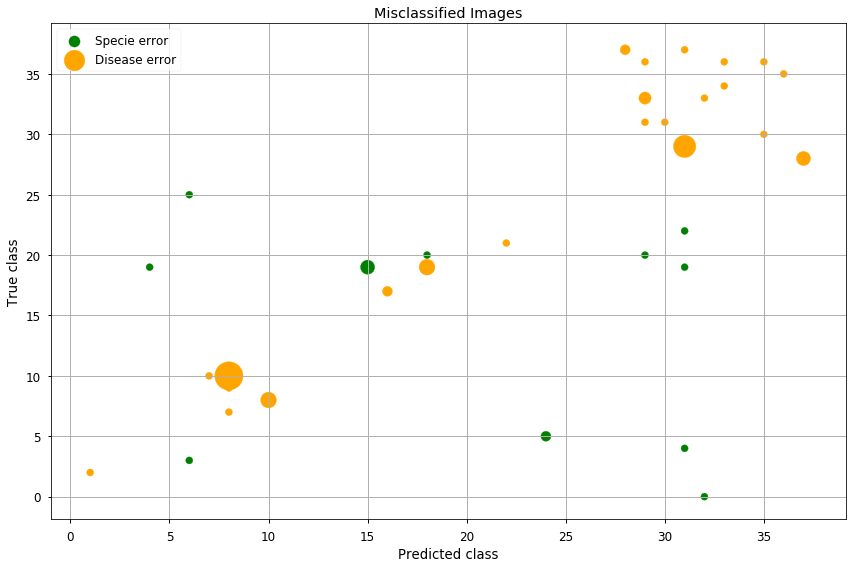

In [43]:
plt.figure(figsize=(12, 8))
plt.scatter(df.pred[df.specie_error==1], df.label[df.specie_error==1], s=df.loc[df.specie_error==1, "count"]*50, color='green');
plt.scatter(df.pred[df.specie_error==0], df.label[df.specie_error==0], s=df.loc[df.specie_error==0, "count"]*50, color='orange');
plt.title('Misclassified Images')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.legend(["Specie error", "Disease error"]);
# Minor ticks
# plt.xticks([4, 5, 7, 11, 15, 16, 18, 20, 23, 24, 25, 26, 28, 38]);
# plt.yticks([4, 5, 7, 11, 15, 16, 18, 20, 23, 24, 25, 26, 28, 38]);
plt.grid();
plt.tight_layout();
plt.savefig("./images/misclassified_images.png")

In [44]:
def format_name(s):
    return re.sub('_+', ' ', s).title()

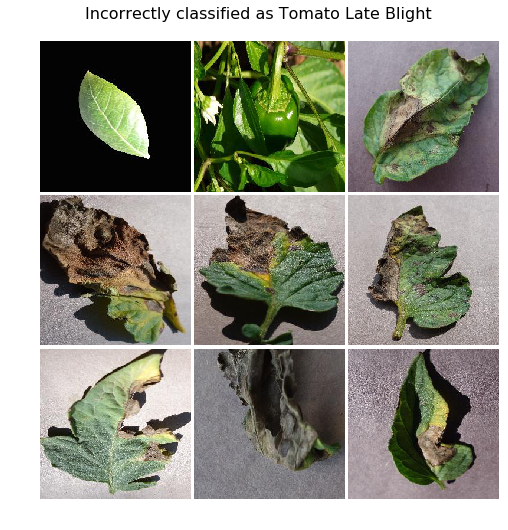

In [45]:
# Examples of incorrectly classified images
pred_idx = 31
df = db_error.loc[db_error.pred == pred_idx,:][:9]
pred_name = format_name(name_mapping.loc[pred_idx, "class_name"])

fig = plt.figure(1, figsize=(12, 8))
grid = ImageGrid(fig, 111, nrows_ncols=(3, 3), axes_pad=0.05)

i = 0

for f, p in zip(df.file.values, df.pred.values):
    ax = grid[i]
    img = image.load_img(VAL_DIR + f, target_size=(256, 256))
    img = image.img_to_array(img)
    ax.imshow(img / 255.)
    ax.axis('off')
    i += 1

plt.suptitle("Incorrectly classified as " + pred_name, fontsize=16);
plt.subplots_adjust(top=0.92);

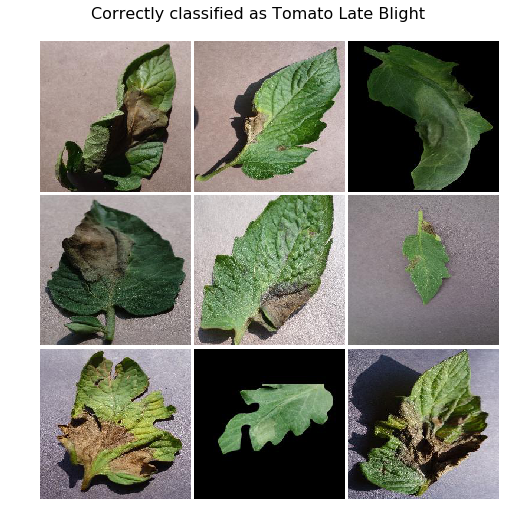

In [46]:
# True examples of incorrectly classified class
idx = 31
df = db.loc[(db.label == idx) & (db.train_ind == 0),:][:9]
pred_name = format_name(name_mapping.loc[idx, "class_name"])

fig = plt.figure(1, figsize=(12, 8))
grid = ImageGrid(fig, 111, nrows_ncols=(3, 3), axes_pad=0.05)

i = 0

for f, p in zip(df.file.values, df.label.values):
    ax = grid[i]
    img = image.load_img(VAL_DIR + f, target_size=(256, 256))
    img = image.img_to_array(img)
    ax.imshow(img / 255.)
    ax.axis('off')
    i += 1

plt.suptitle("Correctly classified as " + pred_name, fontsize=16);
plt.subplots_adjust(top=0.92);

In [47]:
db_error.head()

,file,label,class_name,train_ind,pred
533,Apple___apple_scab/7e64fdef-9cb7-40ed-9f40-f3c...,0,Apple___apple_scab,0,32
1503,Apple___cedar_apple_rust/bee59bef-1155-40bd-97...,2,Apple___cedar_apple_rust,0,1
2848,Apple___healthy/55eca570-7e6f-4bb9-ae2e-b9834d...,3,Apple___healthy,0,6
4568,Blueberry___healthy/ca4ea722-9bf0-4094-bf8b-e1...,4,Blueberry___healthy,0,31
5312,Cherry___healthy/0f93129a-1af1-415b-9d19-c74a1...,5,Cherry___healthy,0,24


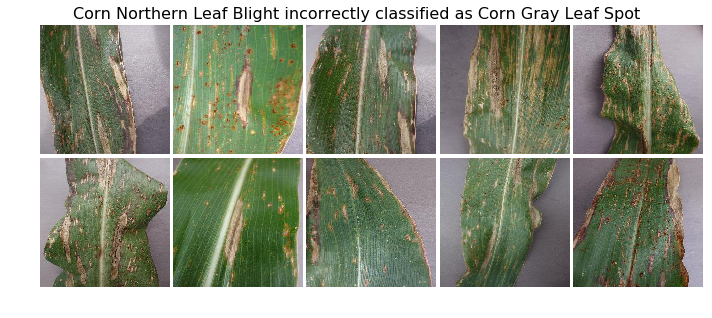

In [48]:
# Examples of incorrectly classified images
pred_idx = 8
label_idx = 10
df = db_error.loc[(db_error.pred == pred_idx) & (db_error.label == label_idx),:][:10]
pred_name = format_name(name_mapping.loc[pred_idx, "class_name"])
label_name = format_name(name_mapping.loc[label_idx, "class_name"])

fig = plt.figure(1, figsize=(10, 4.5))
grid = ImageGrid(fig, 111, nrows_ncols=(2, 5), axes_pad=0.05)

i = 0

for f, p in zip(df.file.values, df.pred.values):
    ax = grid[i]
    img = image.load_img(VAL_DIR + f, target_size=(256, 256))
    img = image.img_to_array(img)
    ax.imshow(img / 255.)
    ax.axis('off')
    i += 1

plt.suptitle(label_name + " incorrectly classified as " + pred_name, fontsize=16);
plt.tight_layout()
plt.savefig("./images/corn_misclassified.png")

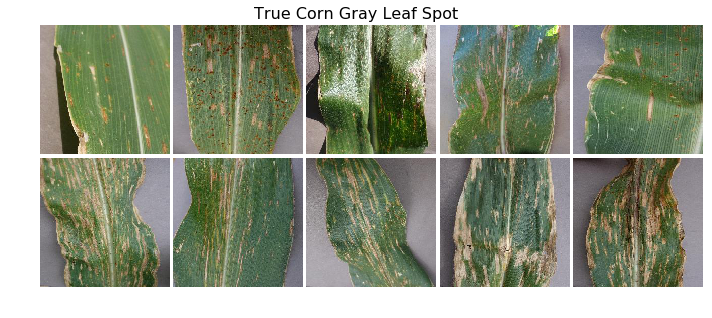

In [61]:
# True examples of incorrectly classified class
idx = 8
df = db.loc[(db.label == idx) & (db.train_ind == 0),:][:10]
pred_name = format_name(name_mapping.loc[idx, "class_name"])

fig = plt.figure(1, figsize=(10, 4.5))
grid = ImageGrid(fig, 111, nrows_ncols=(2, 5), axes_pad=0.05)

i = 0

for f, p in zip(df.file.values, df.label.values):
    ax = grid[i]
    img = image.load_img(VAL_DIR + f, target_size=(256, 256))
    img = image.img_to_array(img)
    ax.imshow(img / 255.)
    ax.axis('off')
    i += 1

plt.suptitle("True " + pred_name, fontsize=16);
plt.tight_layout()
plt.savefig("./images/corn_gray_leaf_spot.png")

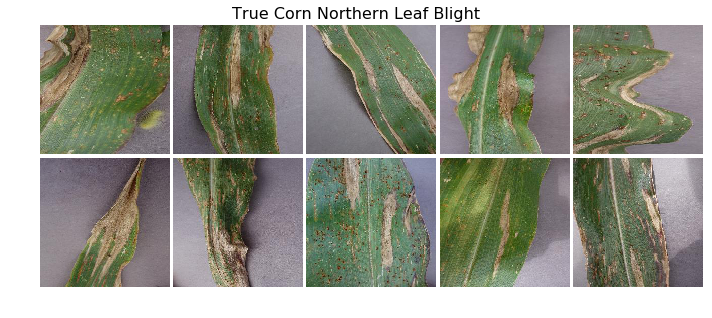

In [50]:
# True examples of incorrectly classified class
idx = 10
df = db.loc[(db.label == idx) & (db.train_ind == 0),:][:10]
pred_name = format_name(name_mapping.loc[idx, "class_name"])

fig = plt.figure(1, figsize=(10, 4.5))
grid = ImageGrid(fig, 111, nrows_ncols=(2, 5), axes_pad=0.05)

i = 0

for f, p in zip(df.file.values, df.label.values):
    ax = grid[i]
    img = image.load_img(VAL_DIR + f, target_size=(256, 256))
    img = image.img_to_array(img)
    ax.imshow(img / 255.)
    ax.axis('off')
    i += 1

plt.suptitle("True " + pred_name, fontsize=16);
plt.tight_layout()
plt.savefig("./images/corn_northern_leaf_blight.png")

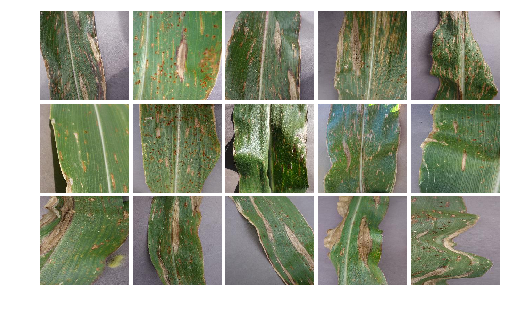

In [64]:
# True examples of incorrectly classified class
pred_idx = 8
label_idx = 10
df = db_error.loc[(db_error.pred == pred_idx) & (db_error.label == label_idx),:][:5]

fig = plt.figure(1, figsize=(10, 4.5))
grid = ImageGrid(fig, 111, nrows_ncols=(3, 5), axes_pad=0.05)

i = 0

for f, p in zip(df.file.values, df.label.values):
    ax = grid[i]
    img = image.load_img(VAL_DIR + f, target_size=(256, 256))
    img = image.img_to_array(img)
    ax.imshow(img / 255.)
    ax.axis('off')
    i += 1
        
idx = 8
df = db.loc[(db.label == idx) & (db.train_ind == 0),:][:5]
pred_name = format_name(name_mapping.loc[idx, "class_name"])

for f, p in zip(df.file.values, df.label.values):
    ax = grid[i]
    img = image.load_img(VAL_DIR + f, target_size=(256, 256))
    img = image.img_to_array(img)
    ax.imshow(img / 255.)
    ax.axis('off')
    i += 1
    
idx = 10
df = db.loc[(db.label == idx) & (db.train_ind == 0),:][:5]
pred_name = format_name(name_mapping.loc[idx, "class_name"])

for f, p in zip(df.file.values, df.label.values):
    ax = grid[i]
    img = image.load_img(VAL_DIR + f, target_size=(256, 256))
    img = image.img_to_array(img)
    ax.imshow(img / 255.)
    ax.axis('off')
    i += 1


plt.tight_layout()
plt.savefig("./images/corn_comparison.png")

## Model comparison

### Performance

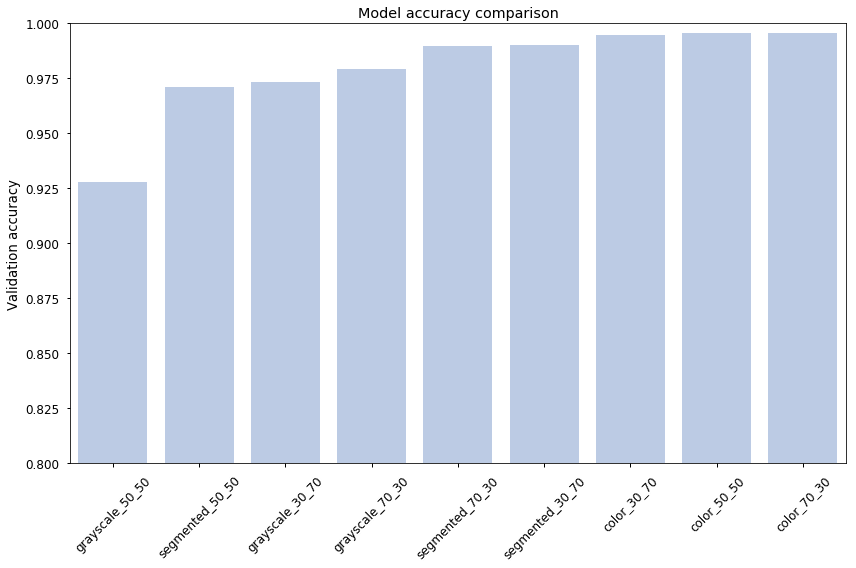

In [51]:
files = [f for f in os.listdir(MODEL_DIR) if ".csv" in f]

i = 0
for f in files:
    df = pd.read_csv(MODEL_DIR + f)
    df['model'] = f.replace(".csv", "")
    df['image_type'] = f.replace(".csv", "")[10:-6]
    df['train_split'] = f.replace(".csv", "")[-5:]
    if i == 0:
        model_results = df
    else:
        model_results = model_results.append(df)   
    i += 1

best_val_acc = {}
for m in set(model_results.model):
    df = model_results.loc[model_results.model == m,]
    val = np.max(df.val_acc)
    best_val_acc[m[10:]] = val

df = pd.DataFrame.from_dict(best_val_acc, orient='index').reset_index()
df.columns = ["model", "val_acc"]
df.sort_values(by="val_acc", inplace=True)

plt.figure(figsize=(12, 8))
sns.barplot(x="model", y="val_acc", data=df, color=vc_color);
plt.title("Model accuracy comparison")
plt.ylabel("Validation accuracy")
plt.xlabel("")
plt.xticks(rotation = 45);
plt.ylim((0.8, 1));
plt.tight_layout();
plt.savefig("./images/model_comparison.png")

### Training / test splits

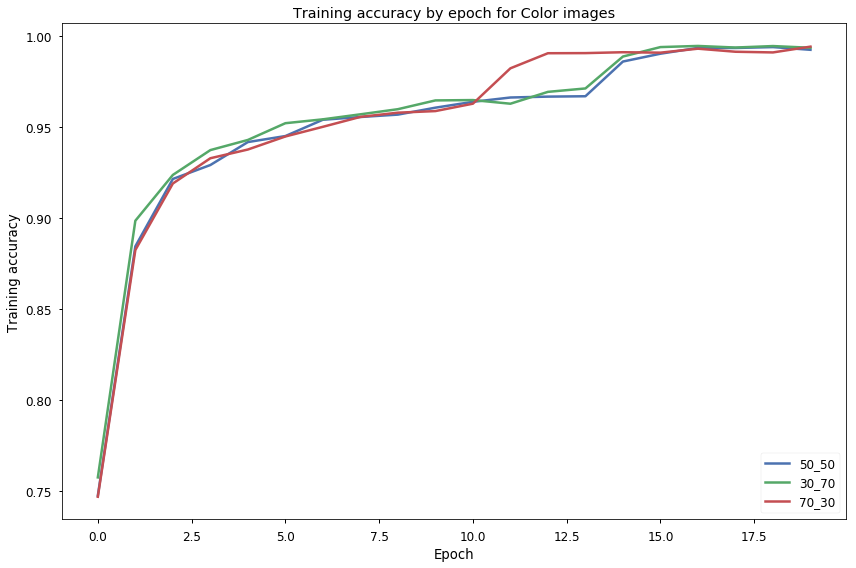

In [52]:
plt.figure(figsize=(12, 8))
df = model_results.loc[model_results.image_type == 'color',:]
for s in set(df.train_split):
    dfp = df.loc[df.train_split == s, :]
    plt.plot(dfp.epoch, dfp.acc, linewidth=2.5);
    plt.legend(set(df.train_split), loc=4);
    plt.xlabel("Epoch");
    plt.ylabel("Training accuracy");
    plt.title("Training accuracy by epoch for Color images");
    plt.tight_layout()
    plt.savefig("./images/training_acc_epoch.png")

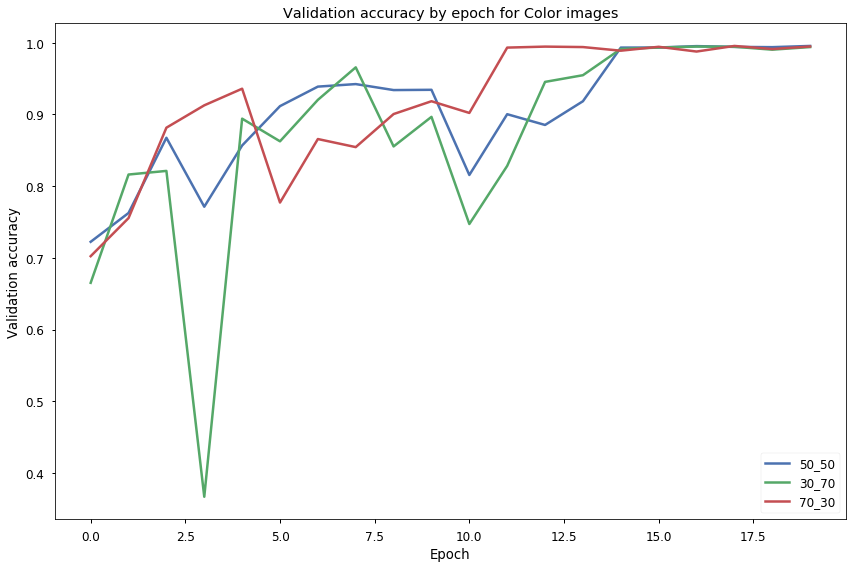

In [53]:
plt.figure(figsize=(12, 8))
df = model_results.loc[model_results.image_type == 'color',:]
for s in set(df.train_split):
    dfp = df.loc[df.train_split == s, :]
    plt.plot(dfp.epoch, dfp.val_acc, linewidth=2.5);
    plt.legend(set(df.train_split), loc=4);
    plt.xlabel("Epoch");
    plt.ylabel("Validation accuracy");
    plt.tight_layout()
    plt.title("Validation accuracy by epoch for Color images");

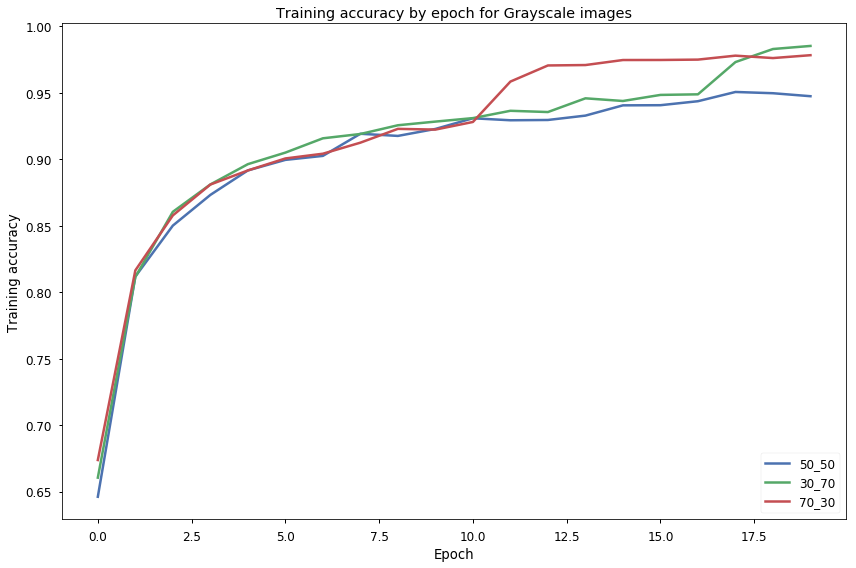

In [54]:
plt.figure(figsize=(12, 8))
df = model_results.loc[model_results.image_type == 'grayscale',:]
for s in set(df.train_split):
    dfp = df.loc[df.train_split == s, :]
    plt.plot(dfp.epoch, dfp.acc, linewidth=2.5);
    plt.legend(set(df.train_split), loc=4);
    plt.xlabel("Epoch");
    plt.ylabel("Training accuracy");
    plt.tight_layout()
    plt.title("Training accuracy by epoch for Grayscale images");

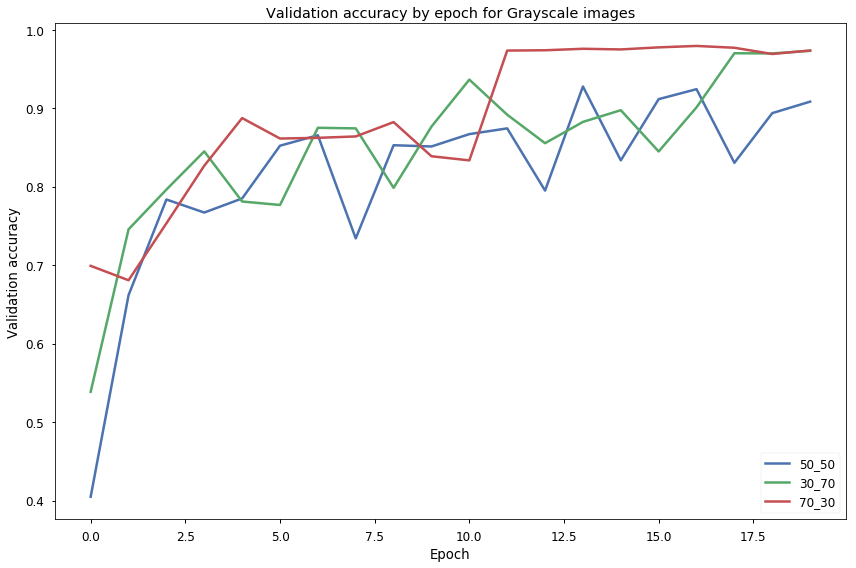

In [55]:
plt.figure(figsize=(12, 8))
df = model_results.loc[model_results.image_type == 'grayscale',:]
for s in set(df.train_split):
    dfp = df.loc[df.train_split == s, :]
    plt.plot(dfp.epoch, dfp.val_acc, linewidth=2.5);
    plt.legend(set(df.train_split), loc=4);
    plt.xlabel("Epoch");
    plt.ylabel("Validation accuracy");
    plt.tight_layout()
    plt.title("Validation accuracy by epoch for Grayscale images")

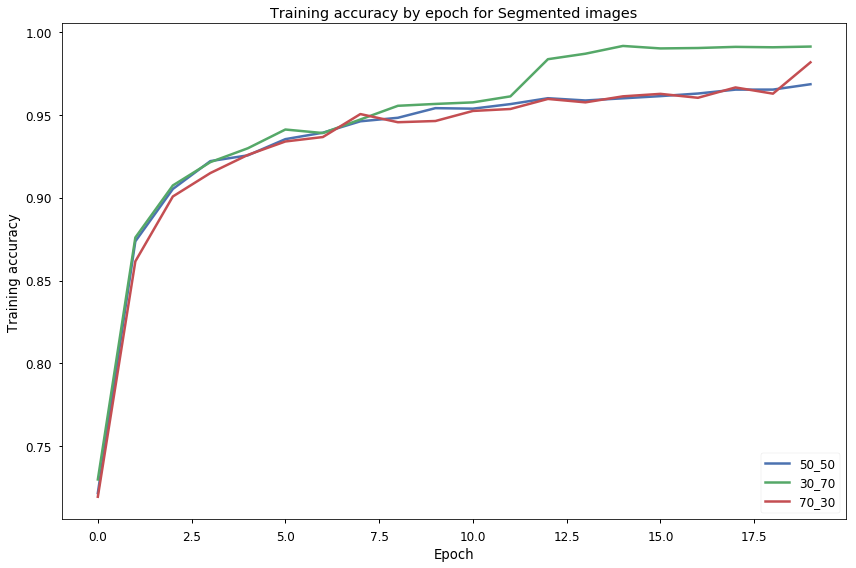

In [56]:
plt.figure(figsize=(12, 8))
df = model_results.loc[model_results.image_type == 'segmented',:]
for s in set(df.train_split):
    dfp = df.loc[df.train_split == s, :]
    plt.plot(dfp.epoch, dfp.acc, linewidth=2.5);
    plt.legend(set(df.train_split), loc=4);
    plt.xlabel("Epoch");
    plt.ylabel("Training accuracy");
    plt.tight_layout()
    plt.title("Training accuracy by epoch for Segmented images");

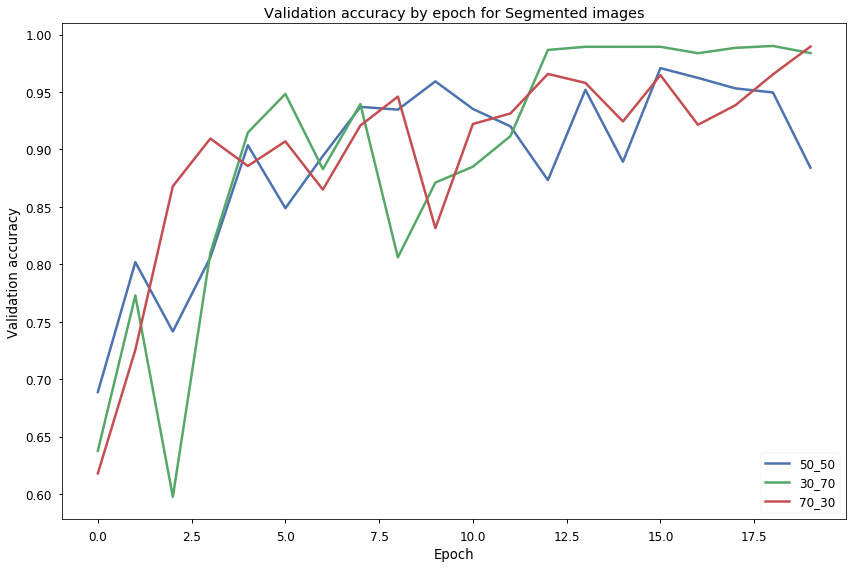

In [57]:
plt.figure(figsize=(12, 8))
df = model_results.loc[model_results.image_type == 'segmented',:]
for s in set(df.train_split):
    dfp = df.loc[df.train_split == s, :]
    plt.plot(dfp.epoch, dfp.val_acc, linewidth=2.5);
    plt.legend(set(df.train_split), loc=4);
    plt.xlabel("Epoch");
    plt.ylabel("Validation accuracy");
    plt.tight_layout()
    plt.title("Validation accuracy by epoch for Segmented images")

### Image types

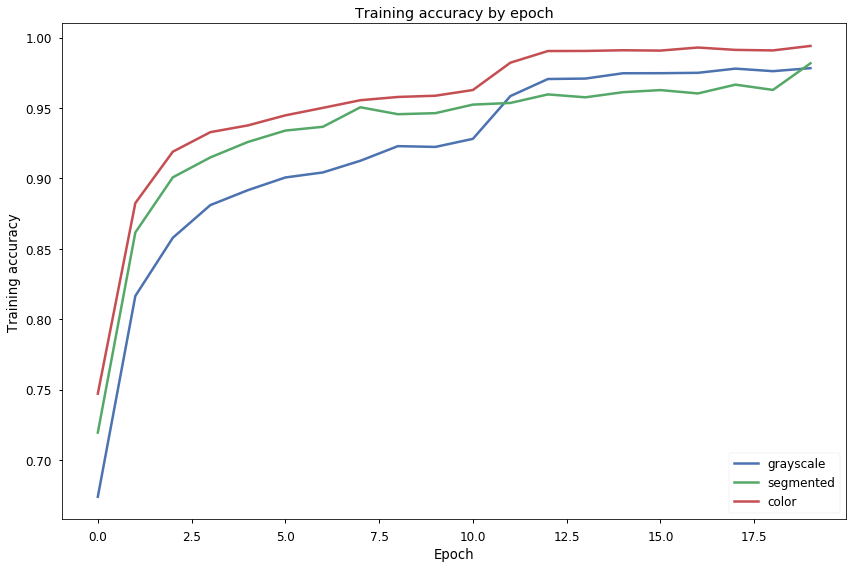

In [58]:
plt.figure(figsize=(12, 8))
df = model_results.loc[model_results.train_split == '70_30',:]
for s in set(df.image_type):
    dfp = df.loc[df.image_type == s, :]
    plt.plot(dfp.epoch, dfp.acc, linewidth=2.5);
    plt.legend(set(df.image_type), loc=4);
    plt.xlabel("Epoch");
    plt.ylabel("Training accuracy");
    plt.tight_layout()
    plt.title("Training accuracy by epoch");

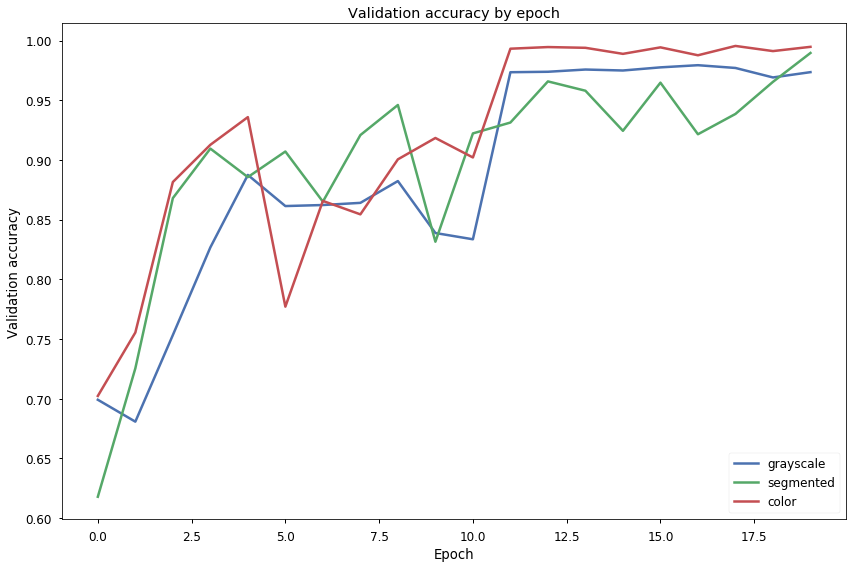

In [59]:
plt.figure(figsize=(12, 8))
df = model_results.loc[model_results.train_split == '70_30',:]
for s in set(df.image_type):
    dfp = df.loc[df.image_type == s, :]
    plt.plot(dfp.epoch, dfp.val_acc, linewidth=2.5);
    plt.legend(set(df.image_type), loc=4);
    plt.xlabel("Epoch");
    plt.ylabel("Validation accuracy");
    plt.tight_layout()
    plt.title("Validation accuracy by epoch");